In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

import utils

In [2]:
#Unet CLASICA (nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
    def forward(self, x ):
        x = self.DownLayer(x)
        return x
    
        
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d(kernel_size = 2)
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.ConvTransp = torch.nn.ConvTranspose2d((in_channels//2), out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = DownConv(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransp(xAnt)
        concat = torch.cat([layerConvTransposed,xDown], dim=1)
        x = self.UpConv(concat)
            
        return x

class OutUnet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(OutUnet, self).__init__()
        self.OutUnet = torch.nn.Conv2d(in_channels,out_channels, kernel_size = 1)
        
    def forward(self,x):
        x = self.OutUnet(x)
        return x

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.Layer1Down = DownConv(1,32)
        self.Layer2Down = DownConv(32,64)
        self.Layer3Down = DownConv(64,128)
        self.Layer4Down = DownConv(128,256)
        self.Layer5Down = DownConv(256,512)
        
        self.Middle = DownConv(512,512)
        
        self.Layer1Up = UpConv(1024,256)
        self.Layer2Up = UpConv(512,128)
        self.Layer3Up = UpConv(256,64)
        self.Layer4Up = UpConv(128,64)
        self.Layer5Up = UpConv(64+32,32)
        
        self.MaxPool = MaxPool()
        
        self.Out = OutUnet(32,1)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.Layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.Layer2Down(maxPool1)
        maxPool2 = self.MaxPool(conv2)
        
        conv3 = self.Layer3Down(maxPool2)
        maxPool3 = self.MaxPool(conv3)
        
        conv4 = self.Layer4Down(maxPool3)
        maxPool4 = self.MaxPool(conv4)
        
        conv5 = self.Layer5Down(maxPool4)
        maxPool5 = self.MaxPool(conv5)
        
        middle = self.Middle(maxPool5)
        
        # Up
        up1= self.Layer1Up(middle,conv5)
        up2= self.Layer2Up(up1,conv4)
        up3= self.Layer3Up(up2,conv3)
        up4= self.Layer4Up(up3,conv2)
        up5= self.Layer5Up(up4,conv1)
        
        outUNet = self.Out(up5)
        
        return outUNet

unet = Unet()

In [3]:
def MSE(img1, img2, cantPix = None):
    cuadradoDeDif = ((img1 - img2) ** 2)
    suma = np.sum(cuadradoDeDif)
    if cantPix == 'None': 
        cantPix = img1.shape[2] * img1.shape[1]  # img1 and 2 should have same shape
    error = suma / cantPix
    return error

In [4]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [5]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]


img_noisyDataSet1 = (np.expand_dims(img_noisyDataSet1, axis=-3)).astype(np.float32)
img_noisyDataSet2 = (np.expand_dims(img_noisyDataSet2, axis=-3)).astype(np.float32)
img_groundTruth = (np.expand_dims(img_groundTruth, axis=-3)).astype(np.float32)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [6]:
# MSE dataset promedio
MSEdataSet1 = []
MSEdataSet2 = []
for i in range(0,img_noisyDataSet1.shape[0]):
    img1 = img_groundTruth[i]
    img2 = img_noisyDataSet1[i]
    img3 = img_noisyDataSet2[i]
    MSEdataSet1.append(MSE(img1,img2))
    MSEdataSet2.append(MSE(img1,img3))

print(np.mean(MSEdataSet1))
print(np.mean(MSEdataSet2))

0.2011082119708667
0.3494163649155729


In [6]:
# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,valid_noisyImage,train_groundTruth,valid_groundTruth = train_test_split(img_noisyDataSet2, img_groundTruth, test_size=0.3)

# Create dictionaries with training sets:
trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])
validSet = dict([('input',valid_noisyImage), ('output', valid_groundTruth)])

print('Data set size. Training set: {0}. Valid set: {1}.'.format(trainingSet['input'].shape[0], validSet['input'].shape[0]))

# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

Data set size. Training set: 1208. Valid set: 518.


In [ ]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Codigo entrenamiento Martin

# defino batches

best_vloss = 1000000000

batchSizeTrain = 4
batchSizeValid = 4
numBatchesTrain = np.round(trainingSet['input'].shape[0] / batchSizeTrain).astype(int)
numBatchesValid = np.round(validSet['input'].shape[0] / batchSizeValid).astype(int)

# Show dev set loss every showDevLossStep batches:
showDevLossStep = 4

printStep = 1
# figImages, axs = plt.subplots(3, 1,figsize=(20,20))
# figLoss, axLoss = plt.subplots(1, 1,figsize=(5,5))

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train
loss_values = []
lossValuesTrainingSet = []
iterationNumbers = []
lossValuesDevSet = []
iterationNumbersForDevSet = []
lossValuesTrainingSetEpoch = []

lossValuesEpoch = []
lossValuesDevSetAllEpoch = []

iter = 0

EPOCHS = 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
    lossValuesTrainingSetEpoch = []
    lossValuesDevSetEpoch = []

    running_loss = 0.0

    unet.train(True)
    for i in range(numBatchesTrain):
        # get the inputs

        inputs = torch.from_numpy(trainingSet['input'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])
        gt = torch.from_numpy(trainingSet['output'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # Save loss values:
        lossValuesTrainingSet.append(loss.item())
        lossValuesTrainingSetEpoch.append(loss.item())
        iterationNumbers.append(iter)

        if i % printStep == (printStep - 1):  # print every printStep mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

            # Show input images:
            # plt.figure(figImages)
            # plt.axes(axs[0])
            # imshow(torchvision.utils.make_grid(inputs, normalize=True))
            # axs[0].set_title('Input Batch {0}'.format(i))
            # plt.axes(axs[1])
            # imshow(torchvision.utils.make_grid(outputs, normalize=True))
            # axs[1].set_title('Output Epoch {0}'.format(epoch))
            # plt.axes(axs[2])
            # imshow(torchvision.utils.make_grid(gt, normalize=True))
            # axs[2].set_title('Ground Truth')
            # Show loss:
            # plt.figure(figLoss)
            # axLoss.plot(iterationNumbers, lossValuesTrainingSet)
            # axLoss.plot(iterationNumbersForDevSet, lossValuesDevSet)
            # plt.draw()
            # plt.pause(0.0001)

            # Update iteration number:
        iter = iter + 1

    lossValuesEpoch.append(np.mean(lossValuesTrainingSetEpoch))
    unet.train(False)
    running_vloss = 0.0


    for i in range(numBatchesValid):
        print(i)

        vinputs = torch.from_numpy(validSet['input'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])
        vgt = torch.from_numpy(validSet['output'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])

        voutputs = unet(vinputs)
        vloss = criterion(voutputs, vgt)
        vloss.backward()
        running_vloss += vloss

        lossValuesDevSet.append(vloss.item())
        
        lossValuesDevSetEpoch.append(vloss.item())


    avg_vloss = np.mean(lossValuesDevSet)
    lossValuesDevSetAllEpoch.append(np.mean(lossValuesDevSetEpoch))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'modelDataSet2_{}_{}'.format(timestamp, epoch)
        torch.save(unet.state_dict(), model_path)

    print('LOSS train {} valid {}'.format(lossValuesEpoch[-1], lossValuesDevSetAllEpoch[-1]))
    # CALCULAR PROMEDIO DE TODOS O VARIOS BATCH

print('Finished Training')

[1,     1] loss: 2.679
[1,     2] loss: 1.586
[1,     3] loss: 0.964
[1,     4] loss: 1.253
[1,     5] loss: 0.856
[1,     6] loss: 0.836
[1,     7] loss: 1.176
[1,     8] loss: 0.850
[1,     9] loss: 0.748
[1,    10] loss: 0.526
[1,    11] loss: 0.875
[1,    12] loss: 0.713
[1,    13] loss: 0.556
[1,    14] loss: 0.302
[1,    15] loss: 0.187
[1,    16] loss: 0.364
[1,    17] loss: 0.360
[1,    18] loss: 0.447
[1,    19] loss: 0.274
[1,    20] loss: 0.607
[1,    21] loss: 0.473
[1,    22] loss: 0.199
[1,    23] loss: 0.634
[1,    24] loss: 0.304
[1,    25] loss: 0.303
[1,    26] loss: 0.182
[1,    27] loss: 0.743
[1,    28] loss: 0.639
[1,    29] loss: 0.449
[1,    30] loss: 0.216
[1,    31] loss: 0.317
[1,    32] loss: 0.169
[1,    33] loss: 0.338
[1,    34] loss: 0.265
[1,    35] loss: 0.156
[1,    36] loss: 0.125
[1,    37] loss: 0.525
[1,    38] loss: 0.279
[1,    39] loss: 0.468
[1,    40] loss: 0.420
[1,    41] loss: 0.143
[1,    42] loss: 0.474
[1,    43] loss: 0.199
[1,    44] 

[2,    35] loss: 0.082
[2,    36] loss: 0.070
[2,    37] loss: 0.247
[2,    38] loss: 0.173
[2,    39] loss: 0.237
[2,    40] loss: 0.205
[2,    41] loss: 0.107
[2,    42] loss: 0.230
[2,    43] loss: 0.122
[2,    44] loss: 0.291
[2,    45] loss: 0.148
[2,    46] loss: 0.215
[2,    47] loss: 0.200
[2,    48] loss: 0.089
[2,    49] loss: 0.131
[2,    50] loss: 0.175
[2,    51] loss: 0.116
[2,    52] loss: 0.149
[2,    53] loss: 0.141
[2,    54] loss: 0.102
[2,    55] loss: 0.092
[2,    56] loss: 0.169
[2,    57] loss: 0.215
[2,    58] loss: 0.144
[2,    59] loss: 0.172
[2,    60] loss: 0.136
[2,    61] loss: 0.286
[2,    62] loss: 0.172
[2,    63] loss: 0.156
[2,    64] loss: 0.194
[2,    65] loss: 0.135
[2,    66] loss: 0.159
[2,    67] loss: 0.189
[2,    68] loss: 0.195
[2,    69] loss: 0.256
[2,    70] loss: 0.196
[2,    71] loss: 0.261
[2,    72] loss: 0.156
[2,    73] loss: 0.229
[2,    74] loss: 0.149
[2,    75] loss: 0.135
[2,    76] loss: 0.185
[2,    77] loss: 0.348
[2,    78] 

[3,    69] loss: 0.200
[3,    70] loss: 0.168
[3,    71] loss: 0.211
[3,    72] loss: 0.088
[3,    73] loss: 0.187
[3,    74] loss: 0.132
[3,    75] loss: 0.040
[3,    76] loss: 0.168
[3,    77] loss: 0.280
[3,    78] loss: 0.183
[3,    79] loss: 0.225
[3,    80] loss: 0.123
[3,    81] loss: 0.140
[3,    82] loss: 0.136
[3,    83] loss: 0.166
[3,    84] loss: 0.104
[3,    85] loss: 0.142
[3,    86] loss: 0.109
[3,    87] loss: 0.145
[3,    88] loss: 0.108
[3,    89] loss: 0.136
[3,    90] loss: 0.147
[3,    91] loss: 0.044
[3,    92] loss: 0.154
[3,    93] loss: 0.125
[3,    94] loss: 0.130
[3,    95] loss: 0.154
[3,    96] loss: 0.214
[3,    97] loss: 0.134
[3,    98] loss: 0.091
[3,    99] loss: 0.157
[3,   100] loss: 0.068
[3,   101] loss: 0.166
[3,   102] loss: 0.162
[3,   103] loss: 0.201
[3,   104] loss: 0.267
[3,   105] loss: 0.253
[3,   106] loss: 0.093
[3,   107] loss: 0.085
[3,   108] loss: 0.236
[3,   109] loss: 0.080
[3,   110] loss: 0.066
[3,   111] loss: 0.092
[3,   112] 

[4,   103] loss: 0.207
[4,   104] loss: 0.254
[4,   105] loss: 0.239
[4,   106] loss: 0.082
[4,   107] loss: 0.085
[4,   108] loss: 0.229
[4,   109] loss: 0.081
[4,   110] loss: 0.051
[4,   111] loss: 0.081
[4,   112] loss: 0.183
[4,   113] loss: 0.149
[4,   114] loss: 0.104
[4,   115] loss: 0.171
[4,   116] loss: 0.124
[4,   117] loss: 0.181
[4,   118] loss: 0.141
[4,   119] loss: 0.169
[4,   120] loss: 0.220
[4,   121] loss: 0.146
[4,   122] loss: 0.102
[4,   123] loss: 0.187
[4,   124] loss: 0.111
[4,   125] loss: 0.102
[4,   126] loss: 0.130
[4,   127] loss: 0.118
[4,   128] loss: 0.076
[4,   129] loss: 0.038
[4,   130] loss: 0.140
[4,   131] loss: 0.116
[4,   132] loss: 0.064
[4,   133] loss: 0.279
[4,   134] loss: 0.140
[4,   135] loss: 0.106
[4,   136] loss: 0.137
[4,   137] loss: 0.076
[4,   138] loss: 0.141
[4,   139] loss: 0.171
[4,   140] loss: 0.154
[4,   141] loss: 0.125
[4,   142] loss: 0.122
[4,   143] loss: 0.161
[4,   144] loss: 0.156
[4,   145] loss: 0.246
[4,   146] 

[5,   137] loss: 0.056
[5,   138] loss: 0.128
[5,   139] loss: 0.166
[5,   140] loss: 0.148
[5,   141] loss: 0.109
[5,   142] loss: 0.115
[5,   143] loss: 0.158
[5,   144] loss: 0.152
[5,   145] loss: 0.223
[5,   146] loss: 0.126
[5,   147] loss: 0.143
[5,   148] loss: 0.173
[5,   149] loss: 0.123
[5,   150] loss: 0.104
[5,   151] loss: 0.100
[5,   152] loss: 0.202
[5,   153] loss: 0.091
[5,   154] loss: 0.118
[5,   155] loss: 0.254
[5,   156] loss: 0.223
[5,   157] loss: 0.126
[5,   158] loss: 0.185
[5,   159] loss: 0.100
[5,   160] loss: 0.035
[5,   161] loss: 0.160
[5,   162] loss: 0.040
[5,   163] loss: 0.121
[5,   164] loss: 0.073
[5,   165] loss: 0.056
[5,   166] loss: 0.088
[5,   167] loss: 0.243
[5,   168] loss: 0.116
[5,   169] loss: 0.088
[5,   170] loss: 0.062
[5,   171] loss: 0.218
[5,   172] loss: 0.108
[5,   173] loss: 0.083
[5,   174] loss: 0.076
[5,   175] loss: 0.202
[5,   176] loss: 0.157
[5,   177] loss: 0.109
[5,   178] loss: 0.171
[5,   179] loss: 0.202
[5,   180] 

[6,   171] loss: 0.214
[6,   172] loss: 0.104
[6,   173] loss: 0.082
[6,   174] loss: 0.074
[6,   175] loss: 0.200
[6,   176] loss: 0.154
[6,   177] loss: 0.106
[6,   178] loss: 0.169
[6,   179] loss: 0.196
[6,   180] loss: 0.281
[6,   181] loss: 0.138
[6,   182] loss: 0.250
[6,   183] loss: 0.167
[6,   184] loss: 0.162
[6,   185] loss: 0.074
[6,   186] loss: 0.125
[6,   187] loss: 0.200
[6,   188] loss: 0.150
[6,   189] loss: 0.105
[6,   190] loss: 0.143
[6,   191] loss: 0.174
[6,   192] loss: 0.186
[6,   193] loss: 0.129
[6,   194] loss: 0.119
[6,   195] loss: 0.223
[6,   196] loss: 0.109
[6,   197] loss: 0.165
[6,   198] loss: 0.111
[6,   199] loss: 0.144
[6,   200] loss: 0.152
[6,   201] loss: 0.205
[6,   202] loss: 0.158
[6,   203] loss: 0.085
[6,   204] loss: 0.156
[6,   205] loss: 0.165
[6,   206] loss: 0.173
[6,   207] loss: 0.134
[6,   208] loss: 0.252
[6,   209] loss: 0.106
[6,   210] loss: 0.148
[6,   211] loss: 0.154
[6,   212] loss: 0.189
[6,   213] loss: 0.152
[6,   214] 

[7,   205] loss: 0.163
[7,   206] loss: 0.170
[7,   207] loss: 0.133
[7,   208] loss: 0.246
[7,   209] loss: 0.106
[7,   210] loss: 0.147
[7,   211] loss: 0.152
[7,   212] loss: 0.185
[7,   213] loss: 0.151
[7,   214] loss: 0.165
[7,   215] loss: 0.163
[7,   216] loss: 0.132
[7,   217] loss: 0.083
[7,   218] loss: 0.137
[7,   219] loss: 0.136
[7,   220] loss: 0.179
[7,   221] loss: 0.101
[7,   222] loss: 0.066
[7,   223] loss: 0.181
[7,   224] loss: 0.114
[7,   225] loss: 0.095
[7,   226] loss: 0.189
[7,   227] loss: 0.091
[7,   228] loss: 0.115
[7,   229] loss: 0.197
[7,   230] loss: 0.162
[7,   231] loss: 0.064
[7,   232] loss: 0.177
[7,   233] loss: 0.179
[7,   234] loss: 0.187
[7,   235] loss: 0.177
[7,   236] loss: 0.194
[7,   237] loss: 0.167
[7,   238] loss: 0.078
[7,   239] loss: 0.103
[7,   240] loss: 0.172
[7,   241] loss: 0.188
[7,   242] loss: 0.105
[7,   243] loss: 0.103
[7,   244] loss: 0.113
[7,   245] loss: 0.133
[7,   246] loss: 0.134
[7,   247] loss: 0.156
[7,   248] 

[8,   239] loss: 0.101
[8,   240] loss: 0.170
[8,   241] loss: 0.187
[8,   242] loss: 0.105
[8,   243] loss: 0.101
[8,   244] loss: 0.111
[8,   245] loss: 0.132
[8,   246] loss: 0.133
[8,   247] loss: 0.155
[8,   248] loss: 0.169
[8,   249] loss: 0.139
[8,   250] loss: 0.139
[8,   251] loss: 0.129
[8,   252] loss: 0.066
[8,   253] loss: 0.127
[8,   254] loss: 0.129
[8,   255] loss: 0.151
[8,   256] loss: 0.095
[8,   257] loss: 0.198
[8,   258] loss: 0.189
[8,   259] loss: 0.090
[8,   260] loss: 0.147
[8,   261] loss: 0.176
[8,   262] loss: 0.199
[8,   263] loss: 0.043
[8,   264] loss: 0.187
[8,   265] loss: 0.139
[8,   266] loss: 0.196
[8,   267] loss: 0.126
[8,   268] loss: 0.219
[8,   269] loss: 0.163
[8,   270] loss: 0.200
[8,   271] loss: 0.157
[8,   272] loss: 0.056
[8,   273] loss: 0.061
[8,   274] loss: 0.199
[8,   275] loss: 0.076
[8,   276] loss: 0.169
[8,   277] loss: 0.086
[8,   278] loss: 0.103
[8,   279] loss: 0.151
[8,   280] loss: 0.094
[8,   281] loss: 0.163
[8,   282] 

[9,   273] loss: 0.060
[9,   274] loss: 0.198
[9,   275] loss: 0.076
[9,   276] loss: 0.167
[9,   277] loss: 0.086
[9,   278] loss: 0.103
[9,   279] loss: 0.149
[9,   280] loss: 0.094
[9,   281] loss: 0.162
[9,   282] loss: 0.167
[9,   283] loss: 0.181
[9,   284] loss: 0.194
[9,   285] loss: 0.151
[9,   286] loss: 0.113
[9,   287] loss: 0.099
[9,   288] loss: 0.161
[9,   289] loss: 0.058
[9,   290] loss: 0.151
[9,   291] loss: 0.168
[9,   292] loss: 0.100
[9,   293] loss: 0.111
[9,   294] loss: 0.202
[9,   295] loss: 0.200
[9,   296] loss: 0.039
[9,   297] loss: 0.255
[9,   298] loss: 0.058
[9,   299] loss: 0.171
[9,   300] loss: 0.070
[9,   301] loss: 0.185
[9,   302] loss: 0.177
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


[10,   295] loss: 0.198
[10,   296] loss: 0.040
[10,   297] loss: 0.251
[10,   298] loss: 0.065
[10,   299] loss: 0.171
[10,   300] loss: 0.069
[10,   301] loss: 0.184
[10,   302] loss: 0.169
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
LOSS train 0.13293054176260108 valid 0.16245730883226944
[11,     1] loss: 0.197
[11,     2] loss: 0.152
[11,     3] loss: 0.109
[11,     4] loss: 0.149
[11,     5] loss: 0.148
[11,     6] loss: 0.142
[11,     7] loss: 0.211
[11,     8] loss: 0.170
[11,     9] loss: 0.159
[11,    10] loss: 0.133
[11,    11] loss: 0.174
[11,    12] loss: 0.185
[11,    13] loss: 0.150
[11,    14] loss: 0.090
[11, 

99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
LOSS train 0.13189357661006862 valid 0.14552280864176842
[12,     1] loss: 0.194
[12,     2] loss: 0.149
[12,     3] loss: 0.108
[12,     4] loss: 0.144
[12,     5] loss: 0.144
[12,     6] loss: 0.143
[12,     7] loss: 0.215
[12,     8] loss: 0.177
[12,     9] loss: 0.152
[12,    10] loss: 0.124
[12,    11] loss: 0.174
[12,    12] loss: 0.187
[12,    13] loss: 0.158
[12,    14] loss: 0.089
[12,    15] loss: 0.026
[12,    16] loss: 0.112
[12,    17] loss: 0.117
[12,    18] loss: 0.156
[12,    19] loss: 0.116
[12,    20] loss: 0.185
[12,    21] loss: 0.151
[12,    22] loss: 0.015
[12,    23] loss: 0.194
[12,    24] loss: 0.125
[12,    25] loss: 0.120
[12,    26] loss: 0.078
[12,    27] loss: 0.221
[12,    28] loss: 0.204
[12,    29] loss: 0.170
[12,    30] loss: 0.098
[12,    31] loss: 0.115
[12,    32] loss: 0.065
[12,    33] loss: 0.142
[12,    34] loss: 0.123
[12,

[13,    14] loss: 0.087
[13,    15] loss: 0.022
[13,    16] loss: 0.111
[13,    17] loss: 0.113
[13,    18] loss: 0.147
[13,    19] loss: 0.111
[13,    20] loss: 0.182
[13,    21] loss: 0.149
[13,    22] loss: 0.015
[13,    23] loss: 0.190
[13,    24] loss: 0.116
[13,    25] loss: 0.113
[13,    26] loss: 0.078
[13,    27] loss: 0.214
[13,    28] loss: 0.202
[13,    29] loss: 0.176
[13,    30] loss: 0.106
[13,    31] loss: 0.117
[13,    32] loss: 0.071
[13,    33] loss: 0.143
[13,    34] loss: 0.128
[13,    35] loss: 0.062
[13,    36] loss: 0.077
[13,    37] loss: 0.193
[13,    38] loss: 0.139
[13,    39] loss: 0.180
[13,    40] loss: 0.154
[13,    41] loss: 0.097
[13,    42] loss: 0.152
[13,    43] loss: 0.103
[13,    44] loss: 0.195
[13,    45] loss: 0.066
[13,    46] loss: 0.157
[13,    47] loss: 0.135
[13,    48] loss: 0.074
[13,    49] loss: 0.109
[13,    50] loss: 0.144
[13,    51] loss: 0.102
[13,    52] loss: 0.074
[13,    53] loss: 0.115
[13,    54] loss: 0.075
[13,    55] loss

[14,    34] loss: 0.126
[14,    35] loss: 0.064
[14,    36] loss: 0.079
[14,    37] loss: 0.202
[14,    38] loss: 0.141
[14,    39] loss: 0.182
[14,    40] loss: 0.152
[14,    41] loss: 0.083
[14,    42] loss: 0.152
[14,    43] loss: 0.107
[14,    44] loss: 0.198
[14,    45] loss: 0.078
[14,    46] loss: 0.161
[14,    47] loss: 0.131
[14,    48] loss: 0.070
[14,    49] loss: 0.107
[14,    50] loss: 0.143
[14,    51] loss: 0.103
[14,    52] loss: 0.074
[14,    53] loss: 0.116
[14,    54] loss: 0.075
[14,    55] loss: 0.071
[14,    56] loss: 0.121
[14,    57] loss: 0.139
[14,    58] loss: 0.120
[14,    59] loss: 0.137
[14,    60] loss: 0.103
[14,    61] loss: 0.187
[14,    62] loss: 0.067
[14,    63] loss: 0.100
[14,    64] loss: 0.153
[14,    65] loss: 0.065
[14,    66] loss: 0.124
[14,    67] loss: 0.128
[14,    68] loss: 0.154
[14,    69] loss: 0.174
[14,    70] loss: 0.146
[14,    71] loss: 0.186
[14,    72] loss: 0.078
[14,    73] loss: 0.156
[14,    74] loss: 0.107
[14,    75] loss

[15,    54] loss: 0.080
[15,    55] loss: 0.071
[15,    56] loss: 0.121
[15,    57] loss: 0.143
[15,    58] loss: 0.116
[15,    59] loss: 0.136
[15,    60] loss: 0.104
[15,    61] loss: 0.184
[15,    62] loss: 0.083
[15,    63] loss: 0.112
[15,    64] loss: 0.155
[15,    65] loss: 0.075
[15,    66] loss: 0.124
[15,    67] loss: 0.129
[15,    68] loss: 0.155
[15,    69] loss: 0.174
[15,    70] loss: 0.147
[15,    71] loss: 0.190
[15,    72] loss: 0.080
[15,    73] loss: 0.159
[15,    74] loss: 0.108
[15,    75] loss: 0.033
[15,    76] loss: 0.151
[15,    77] loss: 0.222
[15,    78] loss: 0.155
[15,    79] loss: 0.180
[15,    80] loss: 0.110
[15,    81] loss: 0.120
[15,    82] loss: 0.125
[15,    83] loss: 0.154
[15,    84] loss: 0.068
[15,    85] loss: 0.126
[15,    86] loss: 0.109
[15,    87] loss: 0.117
[15,    88] loss: 0.089
[15,    89] loss: 0.119
[15,    90] loss: 0.130
[15,    91] loss: 0.033
[15,    92] loss: 0.130
[15,    93] loss: 0.110
[15,    94] loss: 0.110
[15,    95] loss

[16,    74] loss: 0.107
[16,    75] loss: 0.031
[16,    76] loss: 0.150
[16,    77] loss: 0.222
[16,    78] loss: 0.154
[16,    79] loss: 0.178
[16,    80] loss: 0.109
[16,    81] loss: 0.119
[16,    82] loss: 0.124
[16,    83] loss: 0.149
[16,    84] loss: 0.067
[16,    85] loss: 0.125
[16,    86] loss: 0.105
[16,    87] loss: 0.120
[16,    88] loss: 0.088
[16,    89] loss: 0.116
[16,    90] loss: 0.128
[16,    91] loss: 0.033
[16,    92] loss: 0.128
[16,    93] loss: 0.112
[16,    94] loss: 0.109
[16,    95] loss: 0.140
[16,    96] loss: 0.180
[16,    97] loss: 0.118
[16,    98] loss: 0.077
[16,    99] loss: 0.141
[16,   100] loss: 0.070
[16,   101] loss: 0.148
[16,   102] loss: 0.147
[16,   103] loss: 0.185
[16,   104] loss: 0.225
[16,   105] loss: 0.208
[16,   106] loss: 0.065
[16,   107] loss: 0.076
[16,   108] loss: 0.206
[16,   109] loss: 0.071
[16,   110] loss: 0.036
[16,   111] loss: 0.076
[16,   112] loss: 0.165
[16,   113] loss: 0.138
[16,   114] loss: 0.079
[16,   115] loss

[17,    94] loss: 0.111
[17,    95] loss: 0.133
[17,    96] loss: 0.178
[17,    97] loss: 0.116
[17,    98] loss: 0.076
[17,    99] loss: 0.142
[17,   100] loss: 0.067
[17,   101] loss: 0.150
[17,   102] loss: 0.138
[17,   103] loss: 0.171
[17,   104] loss: 0.213
[17,   105] loss: 0.204
[17,   106] loss: 0.066
[17,   107] loss: 0.077
[17,   108] loss: 0.199
[17,   109] loss: 0.070
[17,   110] loss: 0.029
[17,   111] loss: 0.073
[17,   112] loss: 0.161
[17,   113] loss: 0.134
[17,   114] loss: 0.078
[17,   115] loss: 0.149
[17,   116] loss: 0.109
[17,   117] loss: 0.162
[17,   118] loss: 0.124
[17,   119] loss: 0.150
[17,   120] loss: 0.199
[17,   121] loss: 0.129
[17,   122] loss: 0.063
[17,   123] loss: 0.170
[17,   124] loss: 0.093
[17,   125] loss: 0.088
[17,   126] loss: 0.116
[17,   127] loss: 0.099
[17,   128] loss: 0.058
[17,   129] loss: 0.034
[17,   130] loss: 0.119
[17,   131] loss: 0.094
[17,   132] loss: 0.056
[17,   133] loss: 0.207
[17,   134] loss: 0.127
[17,   135] loss

Text(0, 0.5, 'Loss')

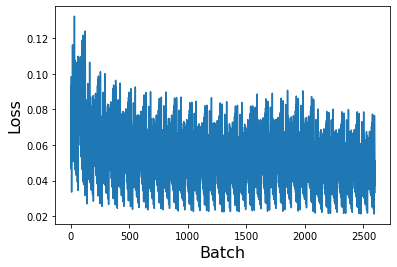

In [10]:
plt.plot(lossValuesDevSet)
plt.xlabel("Batch", size = 16,)
plt.ylabel("Loss", size = 16)

Text(0, 0.5, 'Loss')

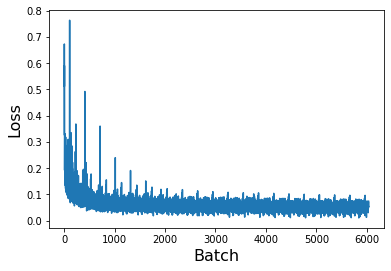

In [11]:
plt.plot(lossValuesTrainingSet)
plt.xlabel("Batch", size = 16,)
plt.ylabel("Loss", size = 16)

Text(0, 0.5, 'Loss')

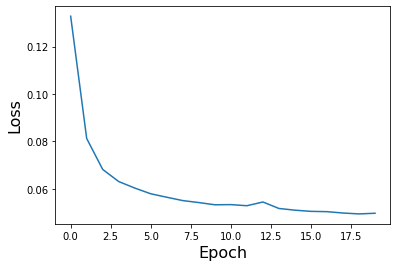

In [12]:
plt.plot(lossValuesEpoch)
plt.xlabel("Epoch", size = 16,)
plt.ylabel("Loss", size = 16)

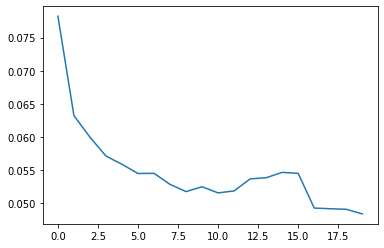

In [13]:
plt.plot(lossValuesDevSetAllEpoch)

In [ ]:
# Test set
# PLANTEAMOS UN CONJUNTO DE TESTEO ROTADO PARA VER LOS RESULTADOS

trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])

inputsTestSet = torch.from_numpy(trainingSet['input'][:,:,:,:])
groundTruthTestSet = torch.from_numpy(trainingSet['output'][:,:,:,:])

inputsTestSet = torchvision.transforms.functional.rotate(inputsTestSet,15)
groundTruthTestSet = torchvision.transforms.functional.rotate(groundTruthTestSet,15)

In [30]:
## Testeo con DataSet Rotado
outArray = []

#for i in range(0,inputsTestSet.shape[0]):
for i in range(0,10):
    inputs =  inputsTestSet[i]
    inputs = torch.unsqueeze(inputs, dim = 0)
    out = unet(inputs)
    outArray.append(out)
    
# MSE antes y dsp

mseBef = []
mseAft = []

# Antes
img1 = torch.unsqueeze(inputsTestSet[9], dim = 0)
img1 = (img1).detach().numpy()

img2 = torch.unsqueeze(groundTruthTestSet[9], dim = 0)
img2 = (img2).detach().numpy()
mseBef.append(MSE(img1[0,:,:],img2[0,:,:]))

# Dsp
imgOut = (outArray[9]).detach().numpy()
mseAft.append(MSE(imgOut[0,:,:],img2[0,:,:]))

print('MSE antes de pasar por la red',mseBef)
print('MSE dsp de pasar por la red',mseAft)

0.21297317780554295
MSE antes de pasar por la red [0.35828256607055664]
MSE dsp de pasar por la red [0.08926944434642792]


In [26]:
# Guardar imagenes (opcional)

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'Entrada.nii')

img_inputs = sitk.GetImageFromArray(imgOut[0,:,:])
sitk.WriteImage(img_inputs,'Salida.nii')

img_out = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_out,'groundTruthUnet.nii')

In [47]:
# TESTEO CON dataSet2

# Create dictionaries with training sets:
testDataSet1 = dict([('input',img_noisyDataSet1), ('output', img_groundTruth)])

inputsTestSet1 = torch.from_numpy(testDataSet1['input'][:,:,:,:])
groundTruthTestSet1 = torch.from_numpy(testDataSet1['output'][:,:,:,:])

In [148]:
## Testeo ....
outArray2 = []

#for i in range(0,inputsTestSet.shape[0]):
for i in range(0,40):
    inputs =  inputsTestSet1[i]
    inputs = torch.unsqueeze(inputs, dim = 0)
    out = unet(inputs)
    outArray1.append(out)
    
# MSE antes y dsp

mseBef2 = []
mseAft2 = []

# Antes
img1 = torch.unsqueeze(inputsTestSet1[30], dim = 0)
img1 = (img1).detach().numpy()

img2 = torch.unsqueeze(groundTruthTestSet1[30], dim = 0)
img2 = (img2).detach().numpy()
mseBef2.append(MSE(img1[0,:,:],img2[0,:,:]))

# Dsp
imgOut = (outArray1[30]).detach().numpy()
mseAft2.append(MSE(imgOut[0,:,:],img2[0,:,:]))

print('MSE antes de pasar por la red',mseBef2)
print('MSE dsp de pasar por la red',mseAft2)

MSE antes de pasar por la red [0.6936010122299194]
MSE dsp de pasar por la red [0.3665635585784912]


In [51]:
img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet2.nii')

img_inputs = sitk.GetImageFromArray(imgOut[0,:,:])
sitk.WriteImage(img_inputs,'SalidaDataSet2.nii')

img_out = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_out,'groundTruthUnetDataSet2.nii')

In [ ]:
# MSE materia gris y materia blanca #

nroSliceDS1 = 9

nroSliceDS2 = 30

# Antes de pasar por la red

# dataSet1
greyMatterNoisyDataSet1Antes = inputsTestSet1[nroSliceDS1] * ((groundTruthTestSet1[nroSliceDS1]==8)*1.0)
whiteMatterNoisyDataSet1Antes = inputsTestSet1[nroSliceDS1] * ((groundTruthTestSet2[nroSliceDS1]==2)*1.0)

greyMatterNoisyDataSet1Dsp = outArray1[nroSliceDS1] * ((groundTruthTestSet1[nroSliceDS1]==8)*1.0)
whiteMatterNoisyDataSet2Dsp = outArray2[nroSliceDS1] * ((groundTruthTestSet1[nroSliceDS1]==2)*1.0)


# dataSet2 rotado
greyMatterNoisyDataSet2RotateAntes = inputsTestSet[nroSliceDS2] * ((groundTruthTestSet[nroSlice2]==8)*1.0)
whiteMatterNoisyDataSet2RotateAntes = inputsTestSet[nroSliceDS2] * ((groundTruthTestSet[nroSlice2]==2)*1.0)

greyMatterNoisyDataSet2RotateDsp = outArray[nroSliceDS2] * ((groundTruthTestSet[nroSlice2]==8)*1.0)
whiteMatterNoisyDataSet2RotateDsp = outArray[nroSliceDS2] * ((groundTruthTestSet[nroSlice2]==2)*1.0)



# Antes y dsp dataSet1

print('DataSet1')

img1 = torch.unsqueeze(greyMatterNoisyDataSet1Antes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet1[nroSliceDS1]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)
img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet1GM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet1GM.nii')

print('Antes GM',MSE(img1[0,:,:],img2[0,:,:], cantPix))

img1 = (greyMatterNoisyDataSet1Dsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet1[nroSliceDS1]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

print('Despues GM',MSE(img1[0,:,:],img2[0,:,:]), cantPix)

img1 = torch.unsqueeze(whiteMatterNoisyDataSet1Antes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet1[nroSliceDS1]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet1WM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet1WM.nii')

print('Antes WM',MSE(img1[0,:,:],img2[0,:,:]),cantPix)


img1 = (whiteMatterNoisyDataSet1Dsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet1[nroSliceDS1]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

print('Despues WM',MSE(img1[0,:,:],img2[0,:,:]), cantPix)


# Antes y dsp dataSet2

print('DataSet2')

img1 = torch.unsqueeze(greyMatterNoisyDataSet2RotateAntes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS2]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

print('Antes GM',MSE(img1[0,:,:],img2[0,:,:]), cantPix)

img1 = (greyMatterNoisyDataSet2RotateDsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS2]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

print('Despues GM',MSE(img1[0,:,:],img2[0,:,:]), cantPix)

img1 = torch.unsqueeze(whiteMatterNoisyDataSet2RotateAntes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS2]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet2WM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet2WM.nii')

print('Antes WM',MSE(img1[0,:,:],img2[0,:,:]), cantPix)

img1 = (whiteMatterNoisyDataSet2RotateDsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS2]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()
cantPix = np.count_nonzero(img2)

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet2WM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet2WM.nii')

print('Despues WM',MSE(img1[0,:,:],img2[0,:,:]),cantPix)